In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')


# Parameters

file_path = '_data/ecg.bin'
file_path = '_data/noise.bin'

fs = 128  # Sampling frequency of the ECG signal
nth = 1  # Use every nth sample
samples_to_strip = 300 * fs  # 15 seconds * 30 Hz
sample_amount = 60 * fs # 20 seconds * 30 Hz

## %matplotlib notebook 
%matplotlib widget


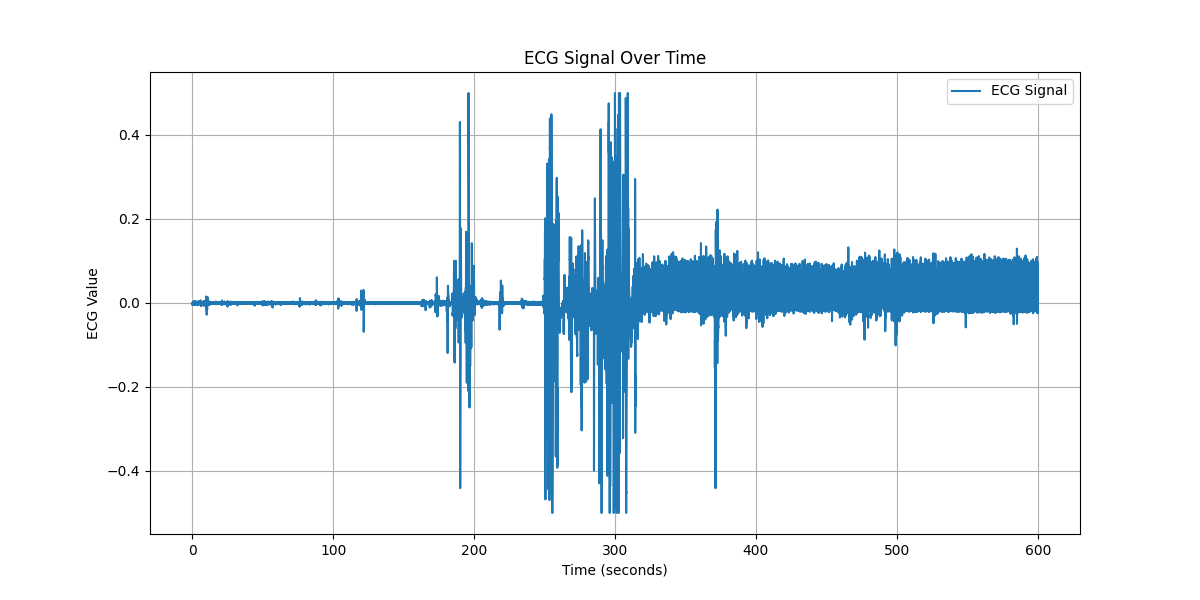

In [2]:

## TODO: why is the data negative?
data = np.fromfile(file_path, dtype=np.float64)

## add noise in the height of 0.1
# data = data + np.random.normal(0, 0.1, len(data))

## discretize the data
# data = (data * 100000).astype(np.int16) 


# use only every 4th sample

# Create a time axis in seconds (data sampled at 30 Hz)
time = np.arange(len(data)) / fs

# Plot the ECG data
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.title('ECG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()

128


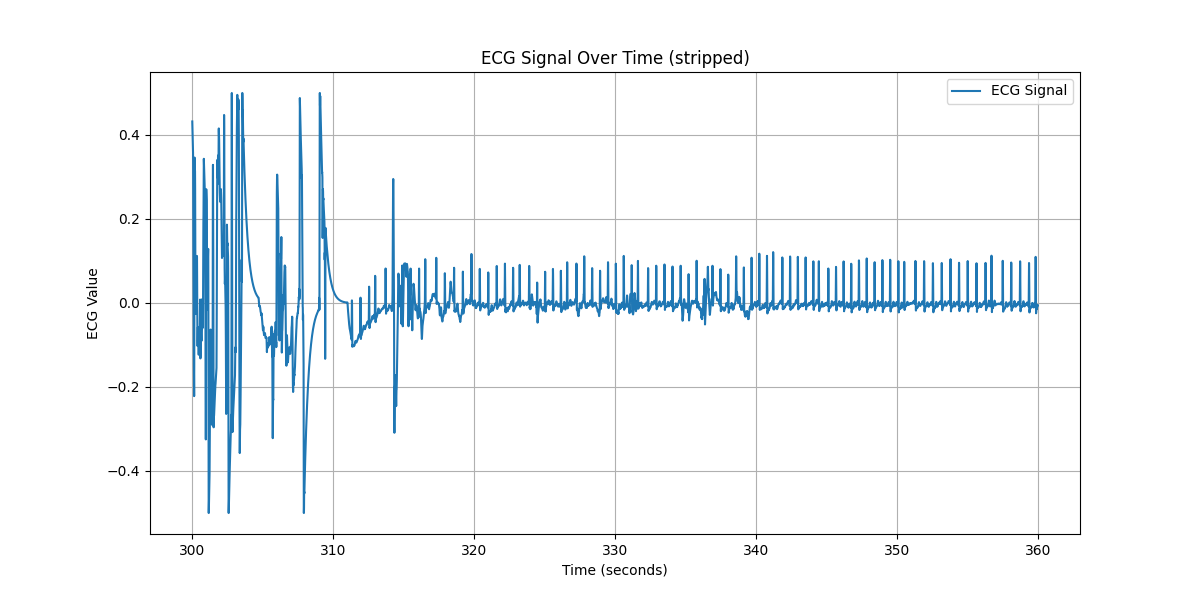

In [3]:
stripped_data = data[samples_to_strip:samples_to_strip+sample_amount:nth]
stripped_time = time[samples_to_strip:samples_to_strip+sample_amount:nth]

fs = fs // nth
print(fs)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, stripped_data, label='ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.title('ECG Signal Over Time (stripped)')
plt.legend()
plt.grid(True)
plt.show()

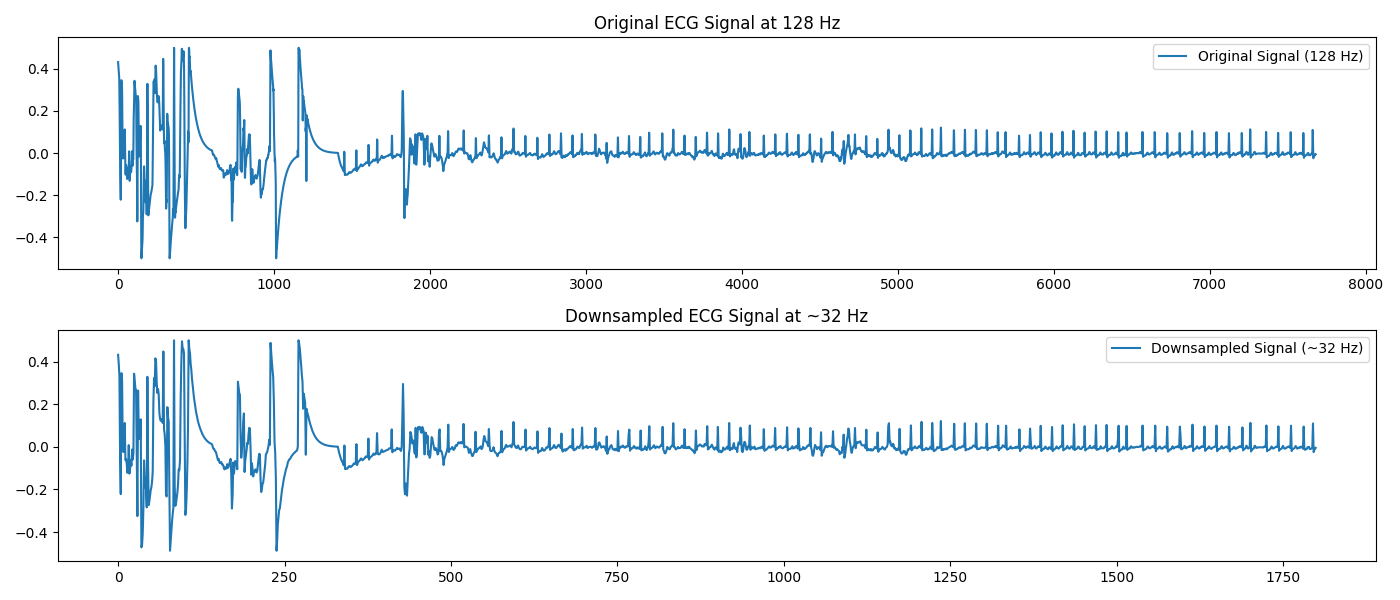

In [4]:
# untested code
import numpy as np
alignment = 0
ecg_signal_128hz = stripped_data
ecg_signal_30hz = [] # is truly 32Hz here, but should not matter

it = 0
idxs = 0
while idxs < len(ecg_signal_128hz):
    idxe = int(12.8*(it+1))
    chunk = ecg_signal_128hz[idxs:idxe]
    max_loc = np.argmax(chunk)
    alignment = max_loc%4
    ecg_signal_30hz += list(chunk[alignment:alignment+10:4])
    idxs=idxe
    it += 1
    
fs = 32

# plot both signals
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(ecg_signal_128hz, label='Original Signal (128 Hz)')
plt.title('Original ECG Signal at 128 Hz')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ecg_signal_30hz, label='Downsampled Signal (~32 Hz)')
plt.title('Downsampled ECG Signal at ~32 Hz')
plt.legend()

plt.tight_layout()
plt.show()

np.array(ecg_signal_30hz).tofile("ecg.bin")

In [5]:
# Normalize the ECG data (subtract mean and divide by standard deviation)

# Calculate the mean and standard deviation of the ECG data
mean_data = np.mean(stripped_data)
std_data = np.std(stripped_data)

# Normalize the ECG data
normalized_data = (stripped_data - mean_data) #/ std_data   ...... not dividing by std_data to keep amplitude for now


[ 1.         -0.88862213]
[ 0.94431106 -0.94431106]
[ 1.         -0.88862213]
[0.05568894 0.05568894]


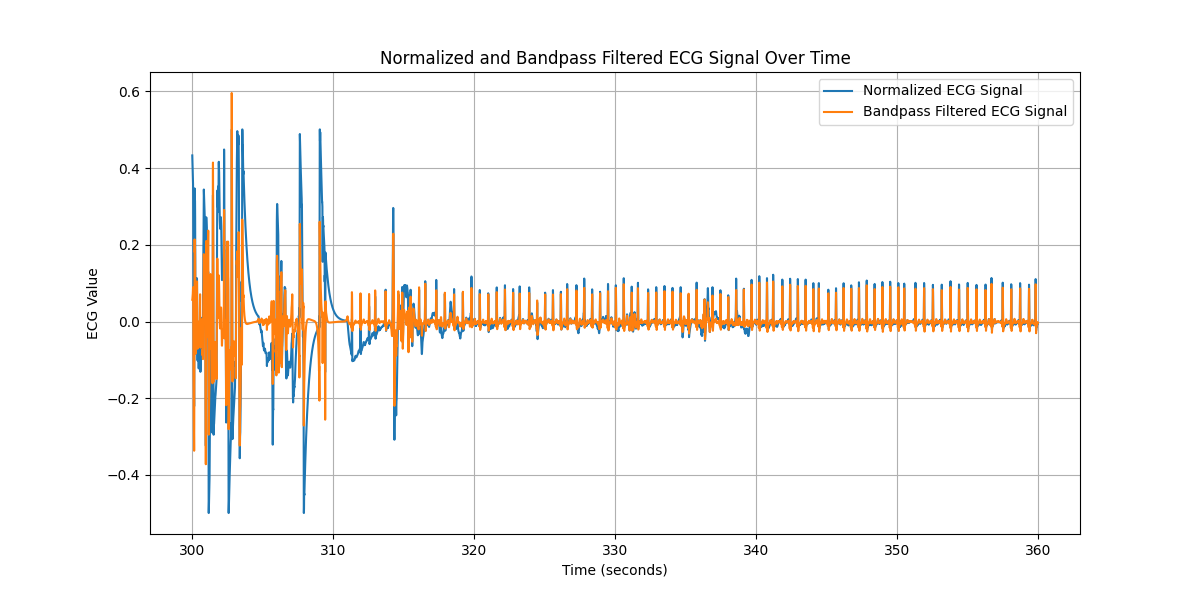

In [6]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    print(a)
    print(b)
    y = filtfilt(b, a, data)
    return y


def butter_lowcut(lowcut, fs, order=5):
    return butter(order, [lowcut], fs=fs, btype='highpass')

def butter_lowcut_filter(data, lowcut, fs, order=5):
    b, a = butter_lowcut(lowcut, fs, order=order)
    print(a)
    print(b)
    y = filtfilt(b, a, data)
    return y


def butter_highcut(highcut, fs, order=5):
    return butter(order, [highcut], fs=fs, btype='lowpass')

def butter_highcut_filter(data, highcut, fs, order=5):
    b, a = butter_highcut(highcut, fs, order=order)
    print(a)
    print(b)
    y = filtfilt(b, a, data)
    return y


lowcut = 0.6  
highcut = 15.0 
order = 1

filtered_data = butter_lowcut_filter(normalized_data, lowcut, fs, order=order)
heavy_lowpass_data = butter_highcut_filter(normalized_data, 0.6, fs, order=order)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, normalized_data, label='Normalized ECG Signal')
plt.plot(stripped_time, filtered_data, label='Bandpass Filtered ECG Signal')
#plt.plot(stripped_time, heavy_lowpass_data, label='Heavy Lowpass Filtered ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.title('Normalized and Bandpass Filtered ECG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()


5


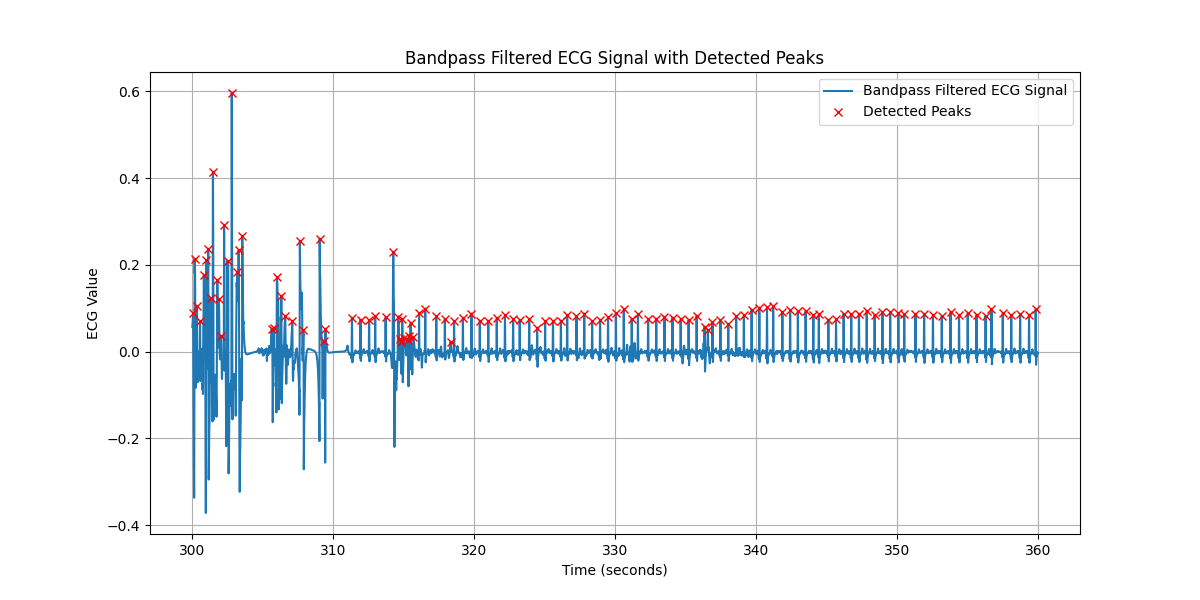

In [7]:
from scipy.signal import find_peaks

# Find the peaks in the filtered ECG signal

max_bpm = 180
distance = int(fs * 60 * 0.5 / max_bpm)
print(distance)
peaks, _ = find_peaks(filtered_data, prominence=0.01, height=0.02, distance=distance, width=3)

# Plot the filtered ECG signal with the peaks
plt.figure(figsize=(12, 6))
plt.plot(stripped_time, filtered_data, label='Bandpass Filtered ECG Signal')
plt.plot(stripped_time[peaks], filtered_data[peaks], 'x', label='Detected Peaks', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.title('Bandpass Filtered ECG Signal with Detected Peaks')
plt.legend()

plt.grid(True)
plt.show()


In [8]:
%%script false --no-raise-error


import numpy as np
from scipy.signal import find_peaks
import random

# Define ranges for each parameter as tuples (min, max)
prominence_range = (np.log(10), np.log(100/100000))
height_range = (np.min(filtered_data), np.max(filtered_data))
threshold_range = (0, 1)  # Adjust scale appropriately
distance_range = (np.log(1), np.log(50))  # Number of samples
width_range = (1, 10)  # Number of samples

# Reference peaks identified with original parameters
ideal_peaks, _ = find_peaks(filtered_data, prominence=5000/100000)

# Number of random trials
n_trials = 10000000

# To store the parameter combinations that match the ideal peaks
matching_parameters = []

for _ in range(n_trials):
    # Generate random parameters within the defined ranges
    prominence = np.exp(random.uniform(*prominence_range))
    height = random.uniform(*height_range)
    threshold = random.uniform(*threshold_range)
    distance = np.exp(random.uniform(*distance_range))
    width = random.uniform(*width_range)

    # Find peaks with randomly generated parameters
    peaks, _ = find_peaks(filtered_data, prominence=prominence, height=height, threshold=threshold, distance=distance, width=width)
    
    # Compare found peaks with ideal peaksx
    if np.array_equal(peaks, ideal_peaks):
        param = {
            'prominence': prominence,
            'height': height,
            'threshold': threshold,
            'distance': distance,
            'width': width
        }
        print(param)
        matching_parameters.append(param)

## get the mean of the parameters
prominence = np.mean([param['prominence'] for param in matching_parameters])
height = np.mean([param['height'] for param in matching_parameters])
threshold = np.mean([param['threshold'] for param in matching_parameters])
distance = np.mean([param['distance'] for param in matching_parameters])
width = np.mean([param['width'] for param in matching_parameters])

print(prominence, height, threshold, distance, width)


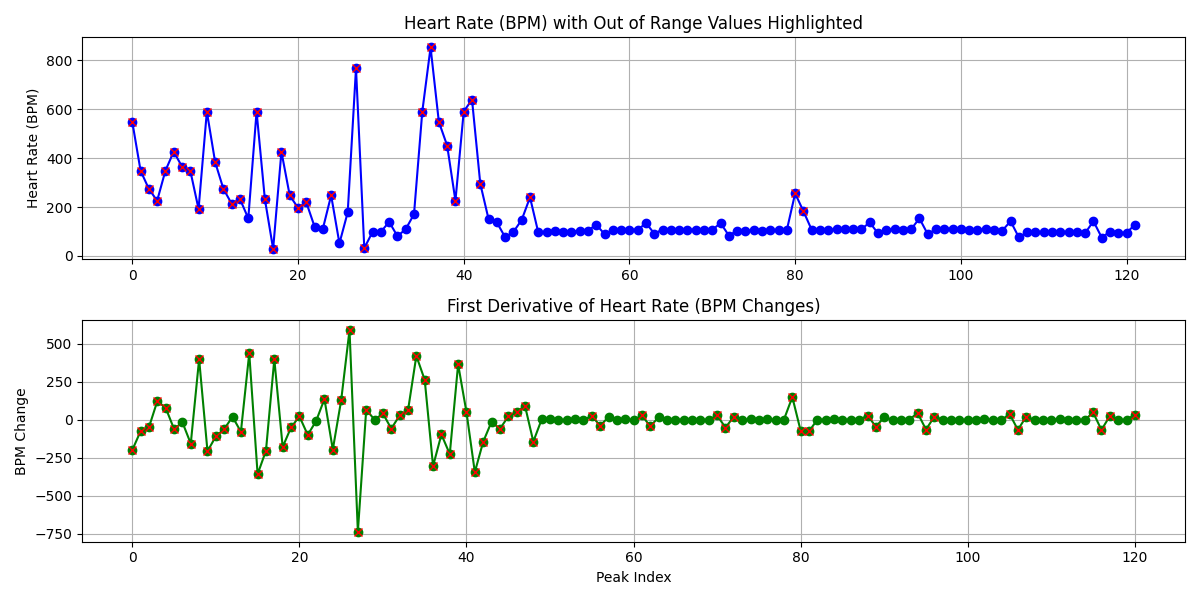

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate BPM as previously defined
peak_times = stripped_time[peaks]
peak_distances = np.diff(peak_times)  # Time between peaks
peak_bpm = 60 / peak_distances

# Define acceptable ranges for BPM
bpm_low = 40   # Reasonable lower limit for BPM
bpm_high = 180 # Reasonable upper limit for BPM

# Identify BPM values that are out of the acceptable range
out_of_range = (peak_bpm < bpm_low) | (peak_bpm > bpm_high)

# Calculate the first derivative of the BPM values
bpm_changes = np.diff(peak_bpm)  # First derivative of BPM

# Define a threshold for acceptable changes in BPM
change_threshold = 20  # Example threshold, modify based on specific requirements

# Identify large changes in BPM that may indicate errors
large_changes = np.abs(bpm_changes) > change_threshold

# Plotting the results with annotations for anomalies
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(peak_bpm, marker='o', linestyle='-', color='blue')
plt.title('Heart Rate (BPM) with Out of Range Values Highlighted')
plt.ylabel('Heart Rate (BPM)')
plt.grid(True)
for i, out in enumerate(out_of_range[:-1]):  # Ignore last value since we can't compute change
    if out:
        plt.plot(i, peak_bpm[i], 'rx')

plt.subplot(2, 1, 2)
plt.plot(bpm_changes, marker='o', linestyle='-', color='green')
plt.title('First Derivative of Heart Rate (BPM Changes)')
plt.xlabel('Peak Index')
plt.ylabel('BPM Change')
plt.grid(True)
for i, large in enumerate(large_changes):
    if large:
        plt.plot(i, bpm_changes[i], 'rx')

plt.tight_layout()
plt.show()
